# American Sign Language - Computer Vision Project

- Dataset: https://public.roboflow.com/object-detection/american-sign-language-letters
- Example Task: https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442

In [1]:
# OVERRIDE_TESTING = False # Set to True to run tests even if not in testing mode

In [2]:
import numpy as np
import tensorflow as tf

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical


tf.__version__

'2.12.0'

In [3]:
# Custom functions:
%load_ext autoreload
%autoreload 2
# sys.path.append(os.path.abspath("../../"))
import custom_functions as cf
help(cf)

Help on package custom_functions:

NAME
    custom_functions

PACKAGE CONTENTS
    ann_functions
    utils

FILE
    /Users/codingdojo/Documents/GitHub/_MY_PROJECTS/computer-vision-american-sign-language/custom_functions/__init__.py




In [4]:
import json, os
from pprint import pprint

# Define filename for project config filepaths json file
FPATHS_FILE = "config/filepaths.json"
os.makedirs(os.path.dirname(FPATHS_FILE), exist_ok=True)

# Define Filepaths
FPATHS = dict(
    data={
        # Images Directoryies
        'data_dir': "./American Sign Language Letters.v1-v1.multiclass/",
        "train-images_dir": "./American Sign Language Letters.v1-v1.multiclass/train/",
        "test-images_dir": "./American Sign Language Letters.v1-v1.multiclass/test/",
        
        # Image classes as csv fiels
        "train-labels_csv": "./American Sign Language Letters.v1-v1.multiclass/train/_classes.csv",
        "test-labels_csv": "./American Sign Language Letters.v1-v1.multiclass/test/_classes.csv",
        
        # Processed versions of the above csv files
        "train-labels_processed_csv": "./American Sign Language Letters.v1-v1.multiclass/train/_classes_processed.csv",
        "test-labels_processed_csv": "./American Sign Language Letters.v1-v1.multiclass/test/_classes_processed.csv",

        },

    images={
        "banner": "images/American_Sign_Language_ASL.svg",
    },
    # Any images to be displayed in the app
    eda={
        "label-distrubtion-countplot_png": "images/label-distribution-countplot.png",
        "test-labels-distrubtion_png": "images/test-label-distribution-countplot.png",
        "example-images_png": "images/ed_example_letters.png",
    },
    modeling={
        "model_dir": "modeling/models/",
            "results_log":"modeling/nn_training.log",
            "results_log_csv":"modeling/nn_training.csv",
            "train-dataset_dir": "modeling/data/training-data-tf/",  # train_ds
            "val-dataset_dir": "modeling/data/validation-data-tf/",  # train_ds
            "test-dataset_dir": "modeling/data/testing-data-tf/",  # test_ds
            "params":"modeling/params.json",
            # "modeling_log": "modeling/modeling.log",

            # "saved_models_list"
            # "best_cnn_fpaths": {'model_dir': "modeling/models/best_cnn/",
            #                           "results_dir": "modeling/models/best_cnn/results/",
            #                           'model_history_png': "modeling/models/best_cnn/results/model_history.png",
            #                             "model_confusion_matrix": "modeling/models/best_cnn/results/model_confusion_matrix.png",
            #                             "model_classification_report": "modeling/models/best_cnn/results/model_classification_report.png",
            #                       },
            # # 'best_model_cnn_dir': "modeling/models/best_cnn/",
            # "best_transfer_fpaths": {'model_dir': "modeling/models/transfer_learning/",
            #                                         "results_dir": "modeling/models/transfer_learning/results/",
            #                                         "model_history_png": "modeling/models/transfer_learning/results/model_history.png",
            #                                         "model_confusion_matrix": "modeling/models/transfer_learning/results/model_confusion_matrix.png",
            #                                         "model_classification_report": "modeling/models/transfer_learning/results/model_classification_report.png",
            # },
                                                    
            # 'transfer_learning_dir': "modeling/models/transfer_learning/",
            "label-lookup_json": "modeling/label_lookup.json",
},
    # config = {'log_fpath': "logs/nn_training.log",},
    readme = {"results_table_md": "modeling/results_table.md",}
)


# Use fn for local package, ds for pip version
cf.utils.create_directories_from_paths(FPATHS)
# ds.utils.create_directories_from_paths(FPATHS)

print('[i] FPATHS Dictionary:\n')
pprint(FPATHS.keys())#, indent=4)

## Save the filepaths
with open(FPATHS_FILE, "w") as f:
    json.dump(FPATHS, f)
    print(f"\n[i] Saved FPATHS to {FPATHS_FILE}")
    
# FPATHS

[i] FPATHS Dictionary:

dict_keys(['data', 'images', 'eda', 'modeling', 'readme'])

[i] Saved FPATHS to config/filepaths.json


In [5]:
# pd.read_csv(FPATHS['modeling']['results_log_csv'])

### 🎛️ Project Params

In [6]:
## Set project-wide parameters
OVERWRITE_LOGS = True

# # Saving image params as vars for reuse
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128

## Set data split proportions
TRAIN_SPLIT = 0.7  # Proportion of data for training
VAL_SPLIT = 0.15  # Proportion of data for validation (remaining will be for test)


# Save model params
PATIENCE = 10  # For early stopping
EPOCHS = 2#0  # Max number of epochs to run
print(f"EPOCHS TEMPORARILY SET TO {EPOCHS}")

import json
## Save model params from above to json
params = {"BATCH_SIZE":BATCH_SIZE,
          "IMG_HEIGHT":IMG_HEIGHT,
          "IMG_WIDTH":IMG_WIDTH,
          "TRAIN_SPLIT":TRAIN_SPLIT,
          "VAL_SPLIT":VAL_SPLIT,
          "PATIENCE":PATIENCE,
          "EPOCHS":EPOCHS}

with open(FPATHS['modeling']['params'], "w") as f:
    json.dump(params, f)
    print(f"\n[i] Saved params to {FPATHS['modeling']['params']}")

EPOCHS TEMPORARILY SET TO 2

[i] Saved params to modeling/params.json


# Load Data

In [7]:
# Checking the contents of data folder
data_dir = FPATHS['data']['data_dir'] #"./American Sign Language Letters.v1-v1.multiclass/"
data_dir

'./American Sign Language Letters.v1-v1.multiclass/'

In [8]:
# Getting list of img file paths (ONLY, did not make recursuve so no folders)
img_files = glob.glob(data_dir+"**/*")#, recursive=True)
len(img_files)

1733

(416, 416, 3)


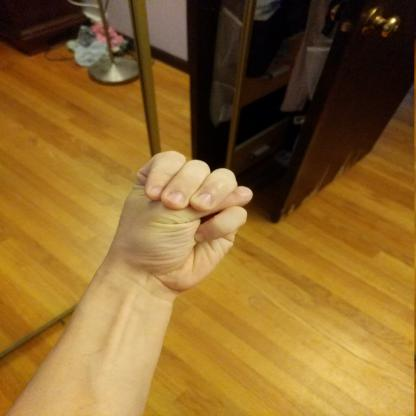

In [9]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
print(img_data.shape)
array_to_img(img_data)

### Prepare CSV of Filenames + Labels (1 per train/test)

In [10]:

# Load the CSV file
# csv_path = os.path.join(data_dir,"train","_classes.csv")
train_csv = FPATHS['data']['train-labels_csv']
df_train = pd.read_csv(train_csv)
df_train = df_train.convert_dtypes()
df_train = df_train.set_index('filename')
df_train = df_train.astype(float)
df_train

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
filename,,,,,,,,,,,,,,,,,,,,,
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
J30_jpg.rf.00d20e595026b31773ded47509545471.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A15_jpg.rf.ff648f0ba648df1d2782e75ddea0f9ba.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J3_jpg.rf.ff86dc5a870f1eadf471751c7fe11941.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A19_jpg.rf.ffe6b49b3b0683ef4eb235ec6c7eca9e.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Saving list of one-hot-encoded labels
label_cols = classes = sorted(df_train.drop(columns=['filename','filepath','label'], errors='ignore').columns)
label_cols

[' A',
 ' B',
 ' C',
 ' D',
 ' E',
 ' F',
 ' G',
 ' H',
 ' I',
 ' J',
 ' K',
 ' L',
 ' M',
 ' N',
 ' O',
 ' P',
 ' Q',
 ' R',
 ' S',
 ' T',
 ' U',
 ' V',
 ' W',
 ' X',
 ' Y',
 ' Z']

In [12]:


# Combine label columns into single column
df_train.loc[:,'label'] = df_train[label_cols].apply(lambda x: x.idxmax(), axis=1)
display(df_train.head(2))

df_train['label'].value_counts(1).sort_index()

,A,B,C,D,E,F,G,H,I,J,...,R,S,T,U,V,W,X,Y,Z,label
filename,,,,,,,,,,,,,,,,,,,,,
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,U
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P


label
A    0.045635
B    0.025794
C    0.035714
D    0.041667
E    0.041667
F    0.039683
G    0.039683
H    0.033730
I    0.051587
J    0.051587
K    0.033730
L    0.047619
M    0.033730
N    0.039683
O    0.035714
P    0.033730
Q    0.039683
R    0.031746
S    0.045635
T    0.027778
U    0.031746
V    0.037698
W    0.037698
X    0.041667
Y    0.031746
Z    0.043651
Name: proportion, dtype: float64

In [13]:
# Save prepend folder path to image filenames
train_img_dir = FPATHS['data']['train-images_dir']

# Save label lookup dictionary
label_lookup = {i:label for i,label in enumerate(classes)}
label_lookup

{0: ' A',
 1: ' B',
 2: ' C',
 3: ' D',
 4: ' E',
 5: ' F',
 6: ' G',
 7: ' H',
 8: ' I',
 9: ' J',
 10: ' K',
 11: ' L',
 12: ' M',
 13: ' N',
 14: ' O',
 15: ' P',
 16: ' Q',
 17: ' R',
 18: ' S',
 19: ' T',
 20: ' U',
 21: ' V',
 22: ' W',
 23: ' X',
 24: ' Y',
 25: ' Z'}

In [14]:
## Get the filepaths and labels
df_train = df_train.reset_index(drop=False)
df_train['filepath'] = df_train.loc[:,'filename'].astype(str).map(lambda x: os.path.join(train_img_dir, x)).values
filepaths = df_train['filepath']

labels = df_train[label_cols].astype(float).values
filepaths[0], labels[0]

('./American Sign Language Letters.v1-v1.multiclass/train/U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [15]:
def prepare_labels_df(csv_fpath, img_dir, return_label_lookup=False, 
                      save_processed_csv=False, processed_csv_fpath=None,
                      save_label_lookup=False, label_lookup_fpath=None):
    
    df = pd.read_csv(csv_fpath)
    
    df = df.convert_dtypes()
    
    # Save label columns
    label_cols = classes = sorted(df.drop(columns=['filename','filepath','label'], errors='ignore').columns)
    # df = df.set_index('filename')
    df[label_cols] = df[label_cols].astype(float)
    
    # Combine labels into single column for EDA
    df.loc[:,'label'] = df[label_cols].apply(lambda x: x.idxmax(), axis=1)
    
    # df = df.reset_index(drop=False)
    
    # Save prepend folder path to image filenames
    df['filepath'] = df.loc[:,'filename'].astype(str).map(lambda x: os.path.join(img_dir, x))
    
    
    if return_label_lookup | save_label_lookup:
        # Save label lookup dictionary
        label_lookup = {i:label for i,label in enumerate(classes)}
    
    if save_label_lookup:
        with open(label_lookup_fpath, "w") as f:
            json.dump(label_lookup, f)
            print(f"\n[i] Saved label lookup to {label_lookup_fpath}")

    
    if save_processed_csv:
        # Save processed csv
        df.to_csv(processed_csv_fpath, index=False)
        print(f"\n[i] Saved processed csv to {processed_csv_fpath}")
    
    if return_label_lookup:
        print("- DataFrame and label lookup dictionary returned.")
        return df, label_lookup
    
    else:
        print("- DataFrame only returned.")
        return df

In [16]:
# Load training data and labels
df_train, label_lookup = prepare_labels_df(FPATHS['data']['train-labels_csv'], 
                             FPATHS['data']['train-images_dir'], 
                             save_label_lookup=True, label_lookup_fpath=FPATHS['modeling']['label-lookup_json'],
                             save_processed_csv=True, processed_csv_fpath=FPATHS['data']['train-labels_processed_csv'],
                             return_label_lookup=True)
df_train.head(2)
label_lookup


[i] Saved label lookup to modeling/label_lookup.json

[i] Saved processed csv to ./American Sign Language Letters.v1-v1.multiclass/train/_classes_processed.csv
- DataFrame and label lookup dictionary returned.


{0: ' A',
 1: ' B',
 2: ' C',
 3: ' D',
 4: ' E',
 5: ' F',
 6: ' G',
 7: ' H',
 8: ' I',
 9: ' J',
 10: ' K',
 11: ' L',
 12: ' M',
 13: ' N',
 14: ' O',
 15: ' P',
 16: ' Q',
 17: ' R',
 18: ' S',
 19: ' T',
 20: ' U',
 21: ' V',
 22: ' W',
 23: ' X',
 24: ' Y',
 25: ' Z'}

In [17]:
# Load training data and labels
df_test = prepare_labels_df(FPATHS['data']['test-labels_csv'], 
                             FPATHS['data']['test-images_dir'], 
                             save_label_lookup=False, 
                             save_processed_csv=True, processed_csv_fpath=FPATHS['data']['test-labels_processed_csv'],
                             return_label_lookup=False)
display(df_test.head(2))


[i] Saved processed csv to ./American Sign Language Letters.v1-v1.multiclass/test/_classes_processed.csv
- DataFrame only returned.


,filename,A,B,C,D,E,F,G,H,I,...,S,T,U,V,W,X,Y,Z,label,filepath
0,T24_jpg.rf.068e7b2424eac996c86bb6d9c38e083d.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,T,./American Sign Language Letters.v1-v1.multicl...
1,Q7_jpg.rf.07fdf6c096cd2a9be72b4de4a627935d.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q,./American Sign Language Letters.v1-v1.multicl...


In [18]:
# Function to load and preprocess images for dataset
def load_image(filename, label, img_height=128, img_width=128):
    img = tf.io.read_file(filename)
    # img = tf.image.decode_image(img, channels=3)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])  # Explicitly set the shape
    img = tf.image.resize(img, [img_height, img_width])
    # img = img / 255.0  # Normalize the image
    return img, label

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


[i] Preview Image (Training Data)
- Label (Category):  U
- Label (OHE): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0.]


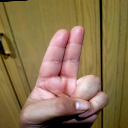

- Image Shape: (128, 128, 3)

[i] Preview Image (Testing Data)
- Label (Category):  T
- Label (OHE): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0.]


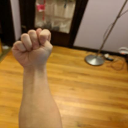

- Image Shape: (128, 128, 3)


In [19]:
# Dispay an example image
i = 0
# filepaths = df_train['filepath']
# labels = df_train[label_cols].astype(float).values

def preview_image(filepaths, labels, i, label_lookup, title=""):
    ex_img, ex_label = load_image(filepaths[i], labels[i])
    
    print("\n[i] Preview Image"+ title)
    print(f"- Label (Category): {label_lookup[np.argmax(ex_label)]}")
    print(f"- Label (OHE): {ex_label}")

    display(array_to_img(ex_img))
    print(f"- Image Shape: {ex_img.shape}")
    
    
    
# Preview an example from training and testing data
preview_image(filepaths=df_train['filepath'].values, labels=df_train[label_cols].values, i=0, label_lookup=label_lookup,
              title=" (Training Data)")

preview_image(filepaths=df_test['filepath'].values, labels=df_test[label_cols].values, i=0,label_lookup=label_lookup,
              title=" (Testing Data)")

### EDA

In [20]:
# eda_df = df_train[['filepath', 'label']]
# eda_df

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_12864/2816741415.py:10: UserWarning: The palette list has more values (26) than needed (24), which may not be intended.
  ax = sns.countplot(data=eda_df, x=x,order=classes,#label_lookup.values(),


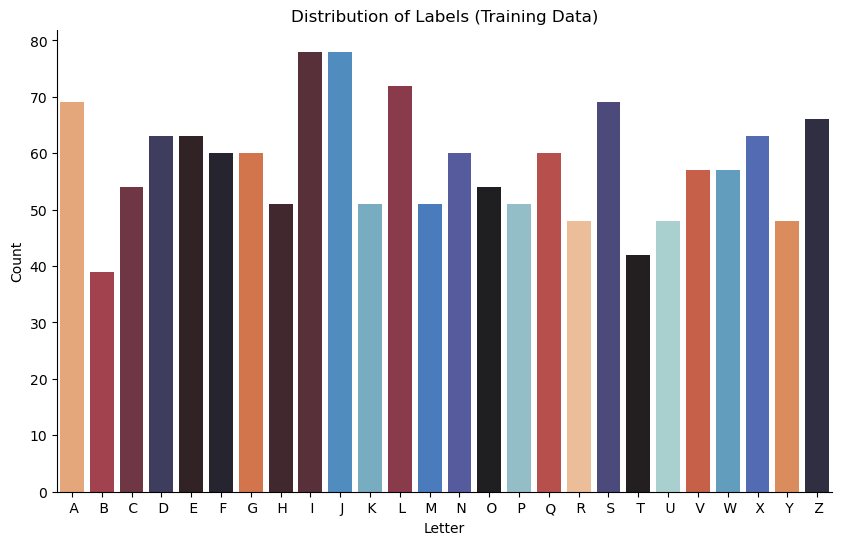

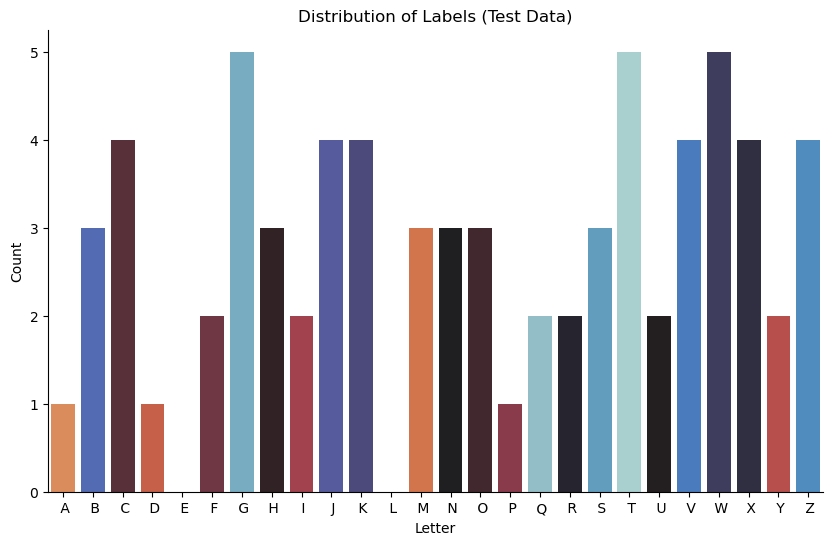

In [21]:
def plot_label_distribution(eda_df, x='label', title="Distribution of Labels (Training Data)", xlabel="Letter", ylabel="Count",
                            label_lookup=None, save_path=None):
    if label_lookup is None:
        classes = sorted(eda_df[x].unique())
    else:
        classes = sorted(label_lookup.values())
    
    # Plot Distrubtion of Labels in Training Data
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.countplot(data=eda_df, x=x,order=classes,#label_lookup.values(),
                hue=x, dodge=False,palette=sns.color_palette("icefire",n_colors=len(classes)),
                ax=ax)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
        
    return fig, ax
        
fig, ax = plot_label_distribution(df_train, title="Distribution of Labels (Training Data)", save_path=FPATHS['eda']['label-distrubtion-countplot_png'],
                                  label_lookup=label_lookup)
fig, ax = plot_label_distribution(df_test, title="Distribution of Labels (Test Data)", save_path=FPATHS['eda']['test-labels-distrubtion_png'],
                                  
                                  label_lookup=label_lookup)
# FPATHS['eda']['label-distrubtion-countplot_png']

#### Display Example of Each

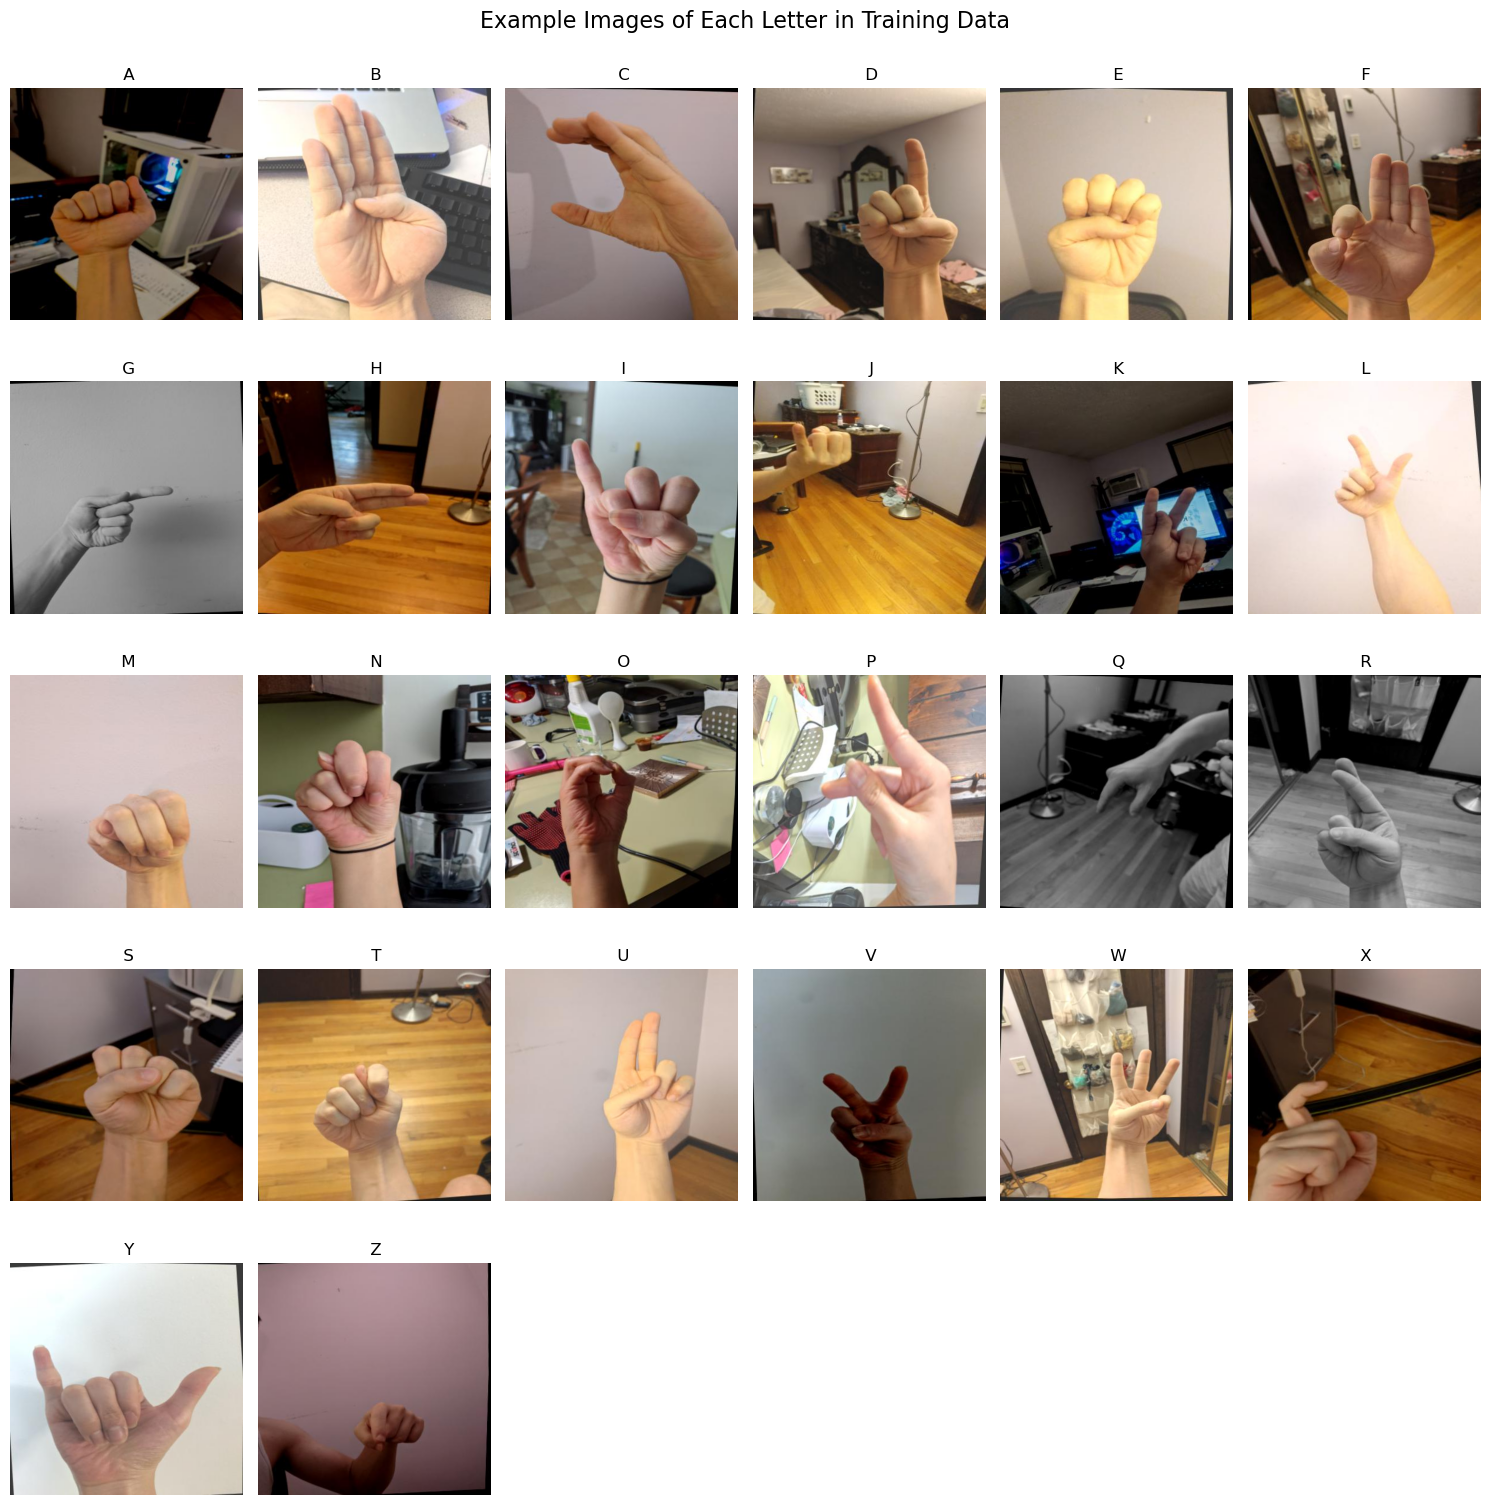

In [22]:
### Plot example of each letter
import os
# os.makedirs("images", exist_ok=True)

def plot_example_images(eda_df,label_col='label',fpath_col = "filepath", ncols = 6,figsize=(15,15),
                        save_path=None, suptitle=None, suptitle_y=1.02, suptitle_fontsize=16):
    # Save labels and determine rows
    unique_labels = sorted(eda_df[label_col].unique())
    nrows = len(unique_labels)//ncols + 1
    
    
    ## Create figure and flatten axes
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    axes = axes.flatten()
    
    # Plot example of each
    for i, label in enumerate(unique_labels):
        # Selet random example of label
        fpath = eda_df.loc[ eda_df[label_col]==label,fpath_col].sample(1).values[0]
        
        # Load and plot the iamge
        loaded = plt.imread(fpath)
        axes[i].imshow(loaded)
        axes[i].set_title(label)
        axes[i].axis('off')
        
    # Remove unused axes    
    axes_labels_diff =  len(axes) - len(unique_labels)
    if axes_labels_diff>0:
        for ax in axes[-axes_labels_diff:]:
            fig.delaxes(ax=ax)   
    
    # Tweak layout
    fig.tight_layout()
    if suptitle is not None:
        fig.suptitle(suptitle, y=suptitle_y, fontsize=suptitle_fontsize)
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
        
    return fig, axes


fig, axes = plot_example_images(df_train, save_path=FPATHS['eda']['example-images_png'],
                                suptitle="Example Images of Each Letter in Training Data")

### Construct Train/Test/Val Tensorflow Datasets

In [23]:
len(df_train), len(df_test)

(1512, 72)

In [24]:
# load_image(image_paths[0], labels[0])

filepaths = df_train['filepath'].values
labels = df_train[label_cols].values
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=False)

dataset.take(1).get_single_element()

(<tf.Tensor: shape=(), dtype=string, numpy=b'./American Sign Language Letters.v1-v1.multiclass/train/C18_jpg.rf.3f6c5a43677a27ecbe3a5796b44f8ddf.jpg'>,
 <tf.Tensor: shape=(26,), dtype=float64, numpy=
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])>)

In [25]:
tf.data.experimental.AUTOTUNE

-1

In [26]:
## Map the load_image function to the dataseta
dataset = dataset.map(lambda x,y: load_image(x,y),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset.take(1).get_single_element()

2024-06-02 19:21:02.741988: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[87.14404   , 84.14404   , 75.14404   ],
         [91.041504  , 88.041504  , 79.041504  ],
         [93.70996   , 90.70996   , 81.70996   ],
         ...,
         [44.        , 55.        , 59.        ],
         [44.        , 55.        , 59.        ],
         [46.        , 57.        , 61.        ]],
 
        [[87.15625   , 84.15625   , 75.15625   ],
         [85.46875   , 82.46875   , 73.46875   ],
         [87.27417   , 84.27417   , 75.27417   ],
         ...,
         [43.        , 54.        , 58.        ],
         [43.        , 54.        , 58.        ],
         [43.765625  , 54.765625  , 58.765625  ]],
 
        [[84.21875   , 81.21875   , 72.21875   ],
         [83.21875   , 80.21875   , 71.21875   ],
         [83.913574  , 80.913574  , 71.913574  ],
         ...,
         [42.390625  , 53.390625  , 57.390625  ],
         [42.390625  , 53.390625  , 57.390625  ],
         [42.390625  , 53.390625  , 57.390625 

In [27]:
# Determine split sizes
total_size = len(dataset)
train_size = int(TRAIN_SPLIT * total_size)
val_size = int(VAL_SPLIT * total_size)
test_size = total_size - train_size - val_size
print(f"{train_size=}, {test_size=}, {val_size=}")


train_size=1058, test_size=228, val_size=226


In [28]:
# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Cache the datset for faster access
train_dataset = train_dataset.cache()
val_dataset = val_dataset.cache()
test_dataset = test_dataset.cache() 


In [29]:
# Batch and prefetch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Shuffle the trainin data
train_dataset = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), 
                                      reshuffle_each_iteration=True) # DOUBLE CHECK BATCH_SIZE * 8


In [30]:

# Use the datasets
for images, labels in train_dataset.take(1):
    print(f"Train batch - images: {images.shape}, labels: {labels.shape}")
    
for images, labels in val_dataset.take(1):
    print(f"Val batch - images: {images.shape}, labels: {labels.shape}")
    
    
for images, labels in test_dataset.take(1):
    print(f"Test batch - images: {images.shape}, labels: {labels.shape}")
    

Train batch - images: (32, 128, 128, 3), labels: (32, 26)
Val batch - images: (32, 128, 128, 3), labels: (32, 26)


2024-06-02 19:21:06.154082: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Test batch - images: (32, 128, 128, 3), labels: (32, 26)


2024-06-02 19:21:06.365456: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Baseline Model (From towardsdatascience blog)
- from https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442


In [31]:
# Moedl from https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442
# from tensorflow
def make_model(name='towards-data-science',show_summary=False, use_schedule=False):
    model = models.Sequential(name=name)
    model.add(layers.Rescaling(1./255 , input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))
    
    model.add(layers.Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' ))#, input_shape = (28,28,1)))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    # Final layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 512 , activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units = len(label_lookup   ) , activation = 'softmax'))
    
    
    ## JMI:
    if use_schedule:
        lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
        )  # 0.9)
        optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.legacy.Adam()#learning_rate=0.01)
        
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    # model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    if show_summary:
        model.summary()
    return model


# Demonstrate model architecture
model = make_model(show_summary=True)

Model: "towards-data-science"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 75)      2100      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 75)     300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 64, 64, 50

#### `def get_callbacks`

In [32]:


def get_callbacks(monitor='val_accuracy', patience=PATIENCE, #15,
                  start_from_epoch=3, restore_best_weights=False):
    """
    Returns a list of callbacks for training a model.

    Parameters:
    - monitor (str): The metric to monitor. Default is 'val_accuracy'.
    - patience (int): The number of epochs with no improvement after which training will be stopped. Default is 15.
    - start_from_epoch (int): The epoch from which to start counting the patience. Default is 3.
    - restore_best_weights (bool): Whether to restore the weights of the best epoch. Default is False.

    Returns:
    - callbacks (list): A list of callbacks to be used during model training.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience,start_from_epoch=start_from_epoch,
                                                      monitor=monitor,
                                                      restore_best_weights=restore_best_weights, verbose=1)
    return [early_stopping]




### Define updated evaluation functions

> With 26 classes, it is difficult to scan the performance for each class visually. Adding code to convert results to a datafarme and use pandas styling to visualize

- added new `get_results_df` to custom_functions

###  New Custom Eval Function: 
- `custom_evaluate_classification_network` (for Notebook use only)

In [33]:
def custom_evaluate_classification_network(model, X_test, history=None, figsize=(15,15), target_names=None,
                                            #  as_frame=True, 
                                             frame_include_macro_avg=True, frame_include_support=False,
                                             display_bar=False, bar_subset_cols = ['recall','precision','f1-score'], 
                                             conf_matrix_text_kws={'fontsize': 'x-small'},
                                             return_figs= True, return_str_report=True):
    """
    Evaluate a classification model on a test dataset.

    Parameters:
    - model: The trained classification model.
    - X_test: The test dataset.
    - history: The training history of the model (optional).
    - figsize: The size of the figure for plotting the evaluation results (default: (15, 15)).
    - target_names: The names of the target classes (default: None).
    - as_frame: Whether to return the evaluation results as a pandas DataFrame (default: True).
    - frame_include_macro_avg: Whether to include macro average metrics in the DataFrame (default: False).
    - frame_include_support: Whether to include support values in the DataFrame (default: False).
    - display_bar: Whether to display the evaluation results as a styled bar chart (default: True).

    Returns:
    - results_dict: A dictionary containing the evaluation results.
    """
    if target_names is None:
        # label_lookup is in the global scope
        target_names = label_lookup.values()
        
    results_dict = cf.evaluate_classification_network(model,
                                                      X_test=X_test,history=history, figsize=figsize,
                                                # Set output to produce a dataframe (no option)
                                                  output_dict=True, as_frame=True,
                                                  target_names=target_names,
                                                  return_fig_conf_matrix=return_figs,
                                                  return_fig_history=return_figs,
                                                    frame_include_macro_avg=frame_include_macro_avg, 
                                                    frame_include_support=frame_include_support,
                                                    values_format=".2f",
                                                    conf_matrix_text_kws=conf_matrix_text_kws,
                                                    return_str_report=return_str_report)
    
    if isinstance(results_dict, tuple):
        results_dict, fig_dict = results_dict

        
        # if isinstance(results_dict, dict):
        #     class_results = results_dict['test']['results-classes']
        #     overall_results = results_dict['test']['results-overall']
        # else:
        #     class_results = results_dict['test']['results-classes']
        #     overall_results = None
        #     # print(results_dict)
    else:
        raise Exception("Results dict not a tuple")
    # elif isinstance(results_dict, dict):
    #     class_results = results_dict['test']['results-classes']
    #     overall_results = results_dict['test']['results-overall']:
        
    return_list = [results_dict]
    
    if display_bar:
        try:
            plot_data = results_dict['test']['results-classes']
            display(plot_data.style.bar(subset=bar_subset_cols, color='#5fba7d').format(formatter= lambda x: f"{x:.2f}").set_caption("Test Data"))
        except:
            display(results_dict)
        
    if return_figs:
        return results_dict, fig_dict
    return results_dict

> 📌BOOKMARK: Controlling Text Size on Confusion Matrix 

In [34]:
# # # TEST CODE (Must run modeling below first)
# results = custom_evaluate_classification_network(model,X_test=test_dataset, history=history, figsize=(15,15),
#                                                  target_names=label_lookup.values(),display_bar=True,);

## Model 1 (with New Function)

In [35]:
## Show model architecture
model = make_model(show_summary=True, use_schedule=False)

Model: "towards-data-science"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 75)      2100      
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 75)     300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 75)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 50

### Logging

In [36]:
log_file = FPATHS['modeling']['results_log']


In [57]:
# Set up logging
import logging
import time
import datetime as dt

def initialize_logs(log_file = 'logs/nn_training.log', overwrite_logs=True,
                    log_header = ";start_time;name;fit_time;metrics;model_filepaths",):
    
    
    # #add deleting log file
    if overwrite_logs==True:
        filemode = "w"
        force=True
    else:
        filemode = 'a'
        force = False
        
    logging.basicConfig(filename=log_file, level=logging.INFO, filemode=filemode,force=force)#, format='%(message)s')
    logging.info(log_header)



# Function to log neural network details
def log_nn_details(start_time, name, fit_time, results_overall,model_filepaths=None,
                #    model_fpath=None, model_classification_report_fpath=None,
                #    model_history_fpath=None, model_confusion_matrix_fpath=None, 
                   sep=";"):
    
    if model_filepaths is not None:
        fpaths_dict= model_filepaths
    else:
        fpaths_dict = "N/A"
        
    
    # Record results (except for filepaths)
    metrics = results_overall.loc['macro avg'].to_dict()
    info = f"{sep}{start_time.strftime('%m/%d/%Y %T')}{sep}{name}{sep}{fit_time}{sep}{metrics}{sep}{fpaths_dict}" 
    
        
    ## Log Info
    logging.info(info)
    
    

def fit_log_model(model, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,fit_kws= {}, callback_kws={}, 
                  save_results=True,model_directory='modeling/models/'):
    # Save start time
    
    start_time = dt.datetime.now()
    
    callbacks = get_callbacks(patience=patience, **callback_kws)
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, verbose=1,
                        callbacks=callbacks, **fit_kws)
    fit_time = dt.datetime.now() - start_time

    results_frames, results_figs = custom_evaluate_classification_network(model,X_test=test_dataset, history=history, figsize=(15,15),
                                                 target_names=label_lookup.values(),display_bar=True,
                                                 frame_include_macro_avg=True, frame_include_support=False)

    if isinstance(results_frames, dict):
        class_results = results_frames['test']['results-classes']
        overall_results = results_frames['test']['results-overall']
        
        # TEMP
        # print(results_figs['test'])
        classification_report = results_figs['test']['classification_report']
    else:
        class_results = results_frames
        overall_results = None
        
    
    
    if overall_results is not None:
        print("\nOverall Results:")
        display(overall_results)
            
    model_results = dict(model=model, history=results_figs['history'],results_classes =class_results,
                results_overall= overall_results, 
                result_figs=results_figs,
                classification_report=classification_report
                )

    # Start saving log details
    log_info = dict(start_time=start_time,  name=model.name, fit_time=fit_time,results_overall=overall_results,
                    
                    model_filepaths=None)
        
    if save_results==True:
        model_filepaths = save_model_results( model_results, model_directory=model_directory,
                                             model_save_format="tf")
        log_info['model_filepaths'] = model_filepaths # dict(model_filepaths=model_filepaths)}
        
    log_nn_details(**log_info)#start_time, model.name, fit_time, overall_results)
        
    return model_results
    # else:
    #     model_filepaths = save_model_results(model_directory, model_results)
            
        
    # return dict(model=model, history=history, results_classes =class_results,
    #             results_overall= overall_results, result_figs=results_figs)
    
    

# Iniialize Logs
initialize_logs(log_file, overwrite_logs=True )#log_header = ";start_time;name;fit_time;metrics")



import os
import tensorflow as tf
import matplotlib.pyplot as plt

def save_model_results(model_results, model_directory='modeling/models', model_save_format='tf'):
    """
    Saves the model, classification report, training history, and confusion matrix to specified directory.
    
    Parameters:
        filepath (str): Base name for the files to be saved.
        model_directory (str): Directory where files will be saved.
        model_results (dict): Dictionary containing model, history, and metrics.
        model_save_format (str): Format to save the model, default is 'tf'.
    
    Returns:
        dict: Dictionary containing paths to the saved files.
        
        
    # Example Usage:
    # model_results = {
    #     'model': tf.keras.models.Sequential([...]),  # Your trained model
    #     'history': plt.figure(),  # A matplotlib figure of your training history
    #     'result_figs': {
    #         'test': {
    #             'classification_report': "Your classification report text",
    #             'confusion_matrix': plt.figure()  # A matplotlib figure of your confusion matrix
    #         }
    #     }
    # }
    # filepaths = save_model_results(', 'model_directory', model_results)
    """
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
    # Use model.name as the base name for the files
    model = model_results['model']
    
    model_directory = os.path.join(model_directory, model.name)
    # model_fpath = os.path.join(model_directory,f"{model.name}")
    

    # Generate file paths
    if model_save_format == 'tf':
        model_save_fpath = model_directory#os.path.join(model_directory,f"{model.name}/")
    else:
        model_save_fpath = os.path.join(model_directory, f"model.{model_save_format}")
        
    # Ensure the model directory exists
    if os.path.isdir(model_save_fpath)==True:
        os.makedirs(model_save_fpath, exist_ok=True)
    else:
        os.makedirs(os.path.dirname(model_save_fpath), exist_ok=True)

    save_classification_report_fpath = os.path.join(model_directory, "classification_report.txt")
    save_history_fpath = os.path.join(model_directory, f"history.png")
    save_confusion_matrix_fpath = os.path.join(model_directory, "confusion_matrix.png")
    
    # Save model
    try:
        model_results['model'].save(model_save_fpath, save_format=model_save_format)
        print(f"- Model saved to {model_save_fpath}")
    except Exception as e:
        print(f"[!] Error saving model: {e}")

    # Save classification report
    try:
        report_str = model_results['classification_report']
        with open(save_classification_report_fpath, "w") as f:
            f.write(report_str)
        print(f"- Classification Report saved to {save_classification_report_fpath}")
    except Exception as e:
        display(f"[!] Error saving classification report: {e}")

    # Save training history
    try:
        history_fig = model_results['history']
        history_fig.savefig(save_history_fpath, dpi=300, bbox_inches='tight', transparent=False)
        print(f"- History figure saved to {save_history_fpath}")
    except Exception as e:
        display(f"[!] Error saving history figure: {e}")
    # Save confusion matrix
    try:
        confusion_matrix_fig = model_results['result_figs']['test']['confusion_matrix']
        confusion_matrix_fig.savefig(save_confusion_matrix_fpath, dpi=300, bbox_inches='tight', transparent=False)
        print(f"- Confusion Matrix figure saved to {save_confusion_matrix_fpath}")
    except Exception as e:
        display(f"[!] Error saving confusion matrix figure: {e}")

    return {
        "model_save_fpath": model_save_fpath, 
        "save_classification_report_fpath": save_classification_report_fpath,
        "save_history_fpath": save_history_fpath, 
        "save_confusion_matrix_fpath": save_confusion_matrix_fpath
    }





Epoch 1/2
34/34 [==============================] - 4s 91ms/step - loss: 4.8110 - accuracy: 0.1276 - val_loss: 3.6007 - val_accuracy: 0.0487
Epoch 2/2
34/34 [==============================] - 3s 76ms/step - loss: 2.1633 - accuracy: 0.4291 - val_loss: 5.9673 - val_accuracy: 0.0708

- Evaluating Network...


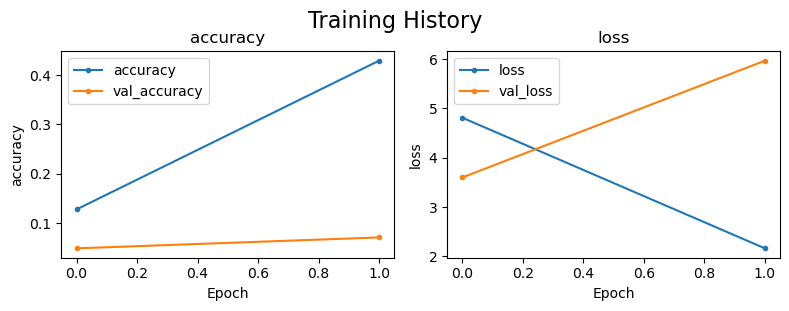


- Evaluating Test Data:
8/8 [==============================] - 0s 30ms/step - loss: 5.7224 - accuracy: 0.0702
{'loss': 5.722445487976074, 'accuracy': 0.07017543911933899} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.03      0.08      0.04        13
           B       0.00      0.00      0.00         5
           C       0.00      0.00      0.00        10
           D       0.00      0.00      0.00         9
           E       0.00      0.00      0.00         9
           F       0.00      0.00      0.00         7
           G       1.00      0.20      0.33        10
           H       0.00      0.00      0.00        10
           I       0.07      0.76      0.13        17
           J       0.00      0.00      0.00         6
           K       0.00      0.00

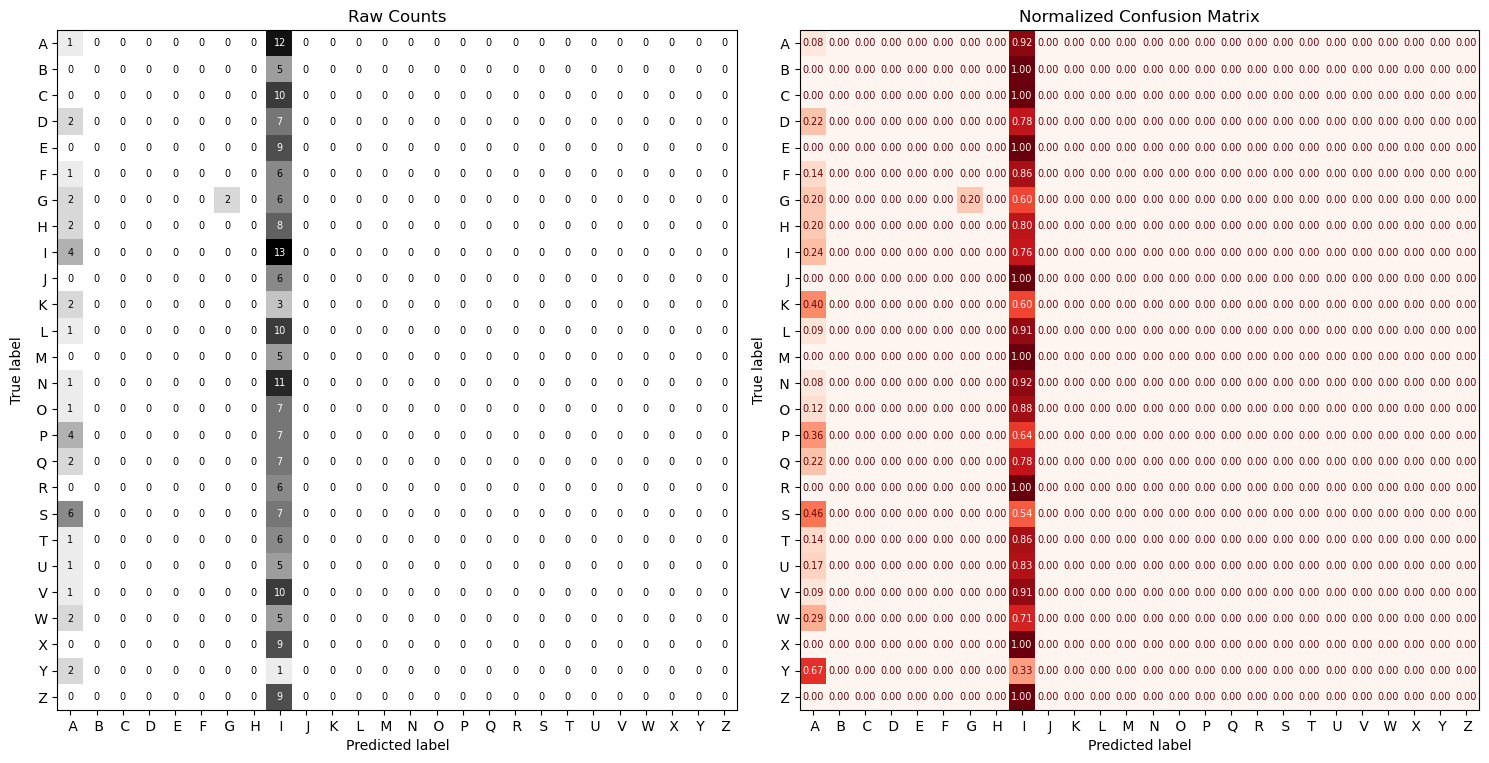

,precision,recall,f1-score
A,0.03,0.08,0.04
B,0.00,0.00,0.00
C,0.00,0.00,0.00
D,0.00,0.00,0.00
E,0.00,0.00,0.00
F,0.00,0.00,0.00
G,1.00,0.20,0.33
H,0.00,0.00,0.00
I,0.07,0.76,0.13
J,0.00,0.00,0.00



Overall Results:


,precision,recall,f1-score,support,accuracy
macro avg,0.042161,0.040063,0.019221,228.0,0.070175


INFO:tensorflow:Assets written to: modeling/models/towards-data-science/assets
- Model saved to modeling/models/towards-data-science
- Classification Report saved to modeling/models/towards-data-science/classification_report.txt
- History figure saved to modeling/models/towards-data-science/history.png
- Confusion Matrix figure saved to modeling/models/towards-data-science/confusion_matrix.png

CPU times: user 9.55 s, sys: 1.2 s, total: 10.7 s
Wall time: 11.6 s


In [59]:
%%time
# Baseline model
model_dir = FPATHS['modeling']['model_dir']
model = make_model(show_summary=False, use_schedule=False)
model_results = fit_log_model(model, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)
print()


In [39]:
# %%time
# # Baseline model
# model = make_model(show_summary=False, use_schedule=False)
# # history = model.fit(train_dataset, epochs = EPOCHS,
# #                     validation_data = val_dataset, callbacks=get_callbacks())
# # # results_dict = cf.evaluate_classification_network(model,X_test=test_dataset,history=history, figsize=(15,15),
# # #                                                   output_dict=True, target_names=label_lookup.values(),
# # #                                                   as_frame=True,
# # #                                                   frame_include_macro_avg=False,frame_include_support=False)
# # results, result_figs = custom_evaluate_classification_network(model,X_test=test_dataset, history=history, figsize=(15,15),
# #                                                  target_names=label_lookup.values(),display_bar=True,);

In [40]:
# model_results.keys()

In [41]:
# model_results['result_figs'].keys()

In [42]:
# model_results['result_figs']['test'].keys()

In [43]:
# cmodel_results['result_figs']

In [44]:
# FPATHS['modeling']['best_cnn_fpaths']

## Bookmark: 06/01 - Parsing and Displaying/Saving DataFrame Logs

In [45]:

# # Testing log file parsing
# with open(log_file, 'r') as file:
#     log_lines = file.readlines()
    
# with open(log_file, 'r') as file:
#     log = file.read()
#     # file.seek(0)
#     # log = file.read()


#     # for line in file:
#     #     print(line.strip())
# # print(log)
# log_lines

In [46]:
# log

In [47]:
# def parse_log_file(log_file,sep=';', keep_only = 'info:root'):##filter_out = ['warning','INFO:tensorflow:asset']):
#     import ast
#     import pandas as pd
    
#     with open(log_file, 'r') as file:
#         log_lines= file.readlines()
    
#     # Remove unwanted lines        
#     split_lines = []
#     for line in log_lines:
#         if line.strip().lower().startswith(keep_only):
    
#             split_lines.append(line.strip().split(sep))
        
#     logs_df = pd.DataFrame(split_lines[1:], columns=split_lines[0])
    
#     logs_df = logs_df.fillna("{}")
#     logs_df['metrics'] = logs_df['metrics'].map(lambda x: ast.literal_eval(x))
#     metrics_df = pd.json_normalize(logs_df['metrics'])
#     logs_df = pd.concat([logs_df.drop(columns=['metrics']),metrics_df],axis=1)

    
#     if 'model_filepaths' in logs_df.columns:
#         logs_df['model_filepaths'] = logs_df['model_filepaths'].map(lambda x: ast.literal_eval(x))
#         fpaths_df = pd.json_normalize(logs_df['model_filepaths'])
#         logs_df = pd.concat([logs_df.drop(columns='model_filepaths'),fpaths_df],axis=1)

#     return logs_df

In [48]:
def parse_log_file(log_file, sep=';', keep_only_startswith=['info:root'], clean_result=False,
                   save_csv=False, save_fpath=None):
    """
    Parses a log file and returns a pandas DataFrame containing the log data.

    Parameters:
    - log_file (str): The path to the log file.
    - sep (str): The separator used to split the log lines into columns. Default is ';'.
    - keep_only (str): The prefix of the lines to keep in the log file. Default is 'info:root'.

    Returns:
    - logs_df (pandas DataFrame): The parsed log data as a DataFrame.

    """
    if (save_fpath is None) and (save_csv==True):
        save_fpath = log_file.replace('.log', '.csv')
    import ast
    import pandas as pd
    
    # Read logs
    with open(log_file, 'r') as file:
        log_lines = file.readlines()
        
    # Remove unwanted lines
    split_lines = []
    for line in log_lines:
        for keep_only in keep_only_startswith:
            if line.strip().lower().startswith(keep_only):
                split_lines.append(line.strip().split(sep))
                # break
        # if line.strip().lower().startswith(keep_only):
        #     split_lines.append(line.strip().split(sep))

    # Create DataFrame
    logs_df = pd.DataFrame(split_lines[1:], columns=split_lines[0])
    
    # Fill NaN values and convert metrics column to dictionary
    logs_df = logs_df.fillna("{}")
    logs_df['metrics'] = logs_df['metrics'].map(lambda x: ast.literal_eval(x))
    metrics_df = pd.json_normalize(logs_df['metrics'])
    
    ## Concatenate metrics columns to main dataframe
    logs_df = pd.concat([logs_df.drop(columns=['metrics']), metrics_df], axis=1)

    # If model_filepaths column exists, convert to dictionary and normalize
    if 'model_filepaths' in logs_df.columns:
        logs_df['model_filepaths'] = logs_df['model_filepaths'].map(lambda x: ast.literal_eval(x))
        fpaths_df = pd.json_normalize(logs_df['model_filepaths'])
        logs_df = pd.concat([logs_df.drop(columns='model_filepaths'), fpaths_df], axis=1)

    if clean_result:
        first_col = logs_df.columns[0]
        logs_df = logs_df.drop(columns=[first_col,'support'], errors='ignore')
        logs_df = logs_df.round(3)
    
    if save_csv:
        logs_df.to_csv(save_fpath, index=False)
        print(f"\n[i] Saved parsed logs to {save_fpath}")
    return logs_df

In [49]:
FPATHS['modeling']['results_log']

'modeling/nn_training.log'

In [50]:
logs_df = parse_log_file(log_file, clean_result=True, save_csv=True, save_fpath=FPATHS['modeling']['results_log_csv'])
logs_df


[i] Saved parsed logs to modeling/nn_training.csv


,start_time,name,fit_time,precision,recall,f1-score,accuracy,model_save_fpath,save_classification_report_fpath,save_history_fpath,save_confusion_matrix_fpath
0,06/02/2024 19:21:12,towards-data-science,0:00:06.985172,0.017,0.047,0.012,0.061,modeling/models/towards-data-science,modeling/models/towards-data-science/classific...,modeling/models/towards-data-science/history.png,modeling/models/towards-data-science/confusion...


In [ ]:
def load_model_results(model_name, model_directory='modeling/models/',
                       load_model=True):
    """
    Loads the model, classification report, training history, and confusion matrix from the specified directory.
    
    Parameters:
        model_name (str): Base name for the files to be loaded.
        model_directory (str): Directory where files are saved.
    
    Returns:
        dict: Dictionary containing the loaded files.
    """
    import os
    import tensorflow as tf
    import matplotlib.pyplot as plt
    
    # Load model
    model_fpath = os.path.join(model_directory, model_name)

    
    # Load classification report
    classification_report_fpath = os.path.join(model_fpath, "classification_report.txt")
    with open(classification_report_fpath, "r") as f:
        classification_report = f.read()
    
    # Load training history
    history_fpath = os.path.join(model_fpath, f"history.png")
    history_fig = plt.imread(history_fpath)
    
    # Load confusion matrix
    confusion_matrix_fpath = os.path.join(model_fpath, "confusion_matrix.png")
    confusion_matrix_fig = plt.imread(confusion_matrix_fpath)
    
    loaded =  {
        "classification_report": classification_report,
        "history_fig": history_fig,
        "confusion_matrix_fig": confusion_matrix_fig
    }
    if load_model:
        model = tf.keras.models.load_model(model_fpath)
    
    loaded['model'] = model
    return loaded

loaded = load_model_results(model_name=logs_df.loc[0,'name'], model_directory= FPATHS['modeling']['model_dir'],
                            load_model=True)#=logs_df.loc[0,'model_save_fpath'])
loaded.keys()

dict_keys(['classification_report', 'history_fig', 'confusion_matrix_fig', 'model'])

In [61]:
loaded['classification_report']

'              precision    recall  f1-score   support\n\n           A       0.00      0.00      0.00        13\n           B       0.00      0.00      0.00         5\n           C       0.00      0.00      0.00        10\n           D       0.20      0.11      0.14         9\n           E       0.00      0.00      0.00         9\n           F       0.00      0.00      0.00         7\n           G       0.00      0.00      0.00        10\n           H       0.00      0.00      0.00        10\n           I       0.00      0.00      0.00        17\n           J       0.00      0.00      0.00         6\n           K       0.00      0.00      0.00         5\n           L       0.06      0.64      0.12        11\n           M       0.02      0.20      0.04         5\n           N       0.00      0.00      0.00        12\n           O       0.00      0.00      0.00         8\n           P       0.00      0.00      0.00        11\n           Q       0.00      0.00      0.00         9\n       

In [62]:

print(loaded['classification_report'])


              precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.00      0.00      0.00         5
           C       0.00      0.00      0.00        10
           D       0.20      0.11      0.14         9
           E       0.00      0.00      0.00         9
           F       0.00      0.00      0.00         7
           G       0.00      0.00      0.00        10
           H       0.00      0.00      0.00        10
           I       0.00      0.00      0.00        17
           J       0.00      0.00      0.00         6
           K       0.00      0.00      0.00         5
           L       0.06      0.64      0.12        11
           M       0.02      0.20      0.04         5
           N       0.00      0.00      0.00        12
           O       0.00      0.00      0.00         8
           P       0.00      0.00      0.00        11
           Q       0.00      0.00      0.00         9
           R       0.00    

In [53]:
loaded['model']

In [54]:
# loaded['model'
#        ].predict(test_dataset)

### ✅ To Do:
- Define a save_results function to use the filepaths in FPATHS to save the results dict

In [55]:
pd.read_csv()

TypeError: read_csv() missing 1 required positional argument: 'filepath_or_buffer'

In [ ]:
tf.keras.models.load_model(model_results['model_save_fpath'])

In [ ]:
# results_frames['test'].keys()

In [ ]:
results_frames['test']['results-classes']

In [ ]:
results_frames['test']['results-overall']

In [ ]:
# # save datasets
# train_dataset.save(FPATHS['modeling']['train-dataset_dir'])
# test_dataset.save(FPATHS['modeling']['test-dataset_dir'])
# val_dataset.save(FPATHS['modeling']['val-dataset_dir'])

In [ ]:
# model.save?

In [ ]:
FPATHS['modeling']['best_cnn_fpaths']

In [ ]:
fig

### Writing Save Function:

- Notes:
    - Need to save:
        - `figs_dict`:
            - 

In [ ]:

# try:
    
#     # Save the model
#     model.save(FPATHS['modeling']['best_model_cnn_fpaths']['model_dir'], save_format='tf')

# except Exception as e:
#     display(f"[i] Error saving model: {e}")


In [ ]:
FPATHS['modeling']['best_cnn_fpaths']

In [ ]:
# print('Results dict:')
# print(results.keys())
# print(results['test'].keys())


# print('\nFigs Dict')
# print(figs.keys())
# print(figs['test'].keys())

# def save_results(figs,model_key=None,FPATHS=None, results=None): 
#                 #  history_fpath=None, conf_matrix_fpath_train=None, 
#                 #  conf_matrix_fpath_test=None,
#                 #  classification_report_fpath=None # not used yet
#                 #  ):
    
#     # if (model_key is not None) & (FPATHS is not None):
#     model_fpaths = FPATHS['modeling'][model_key]
#     history_fpath = model_fpaths.get('model_history_png',None)
#     conf_matrix_fpath_train = model_fpaths.get('model_confusion_matrix',None)
#     conf_matrix_fpath_test = model_fpaths.get('model_confusion_matrix',None)
    
#     if 'history' in figs.keys():
#         if history_fpath is None:
#             history_fpath = FPATHS['results']['best_model_cnn_history']
#         figs['history'].savefig(history_fpath, dpi=300, bbox_inches='tight', transparent=False)
#         print(f"\n[i] Saved history plot to {history_fpath}")

#     for split in ['train','test']:
#         if split in figs:
#             figs_split = figs[split]
            
#             if 'confusion_matrix' in figs_split.keys():
#                 conf_matrix_fpath_train
#             # if conf_matrix_fpath_train is None:
#                 # conf_matrix_fpath_train = FPATHS['results']['best_model_cnn_confusion_matrix']
                    
#                 figs['confusion_matrix'].savefig(conf_matrix_fpath_train, dpi=300, bbox_inches='tight', transparent=False)
#                 print(f"\n[i] Saved {split} confusion matrix plot to {conf_matrix_fpath_test}") 
                
                   

In [ ]:
# save_results(figs, history_fpath=FPATHS['results']['best_model_cnn_classification_report'], conf_matrix_fpath_train=None, 
#                  conf_matrix_fpath_test=None,
#                  classification_report_fpath=None # not used yet
#                  )
    

In [ ]:
# raise Exception("finish writing save_results function above.")
# if OVERRIDE_TESTING:
#     raise Exception("finish testing custom_evaluate_classification_network in eval function above.")
# # raise Exception("finish testing conf_matrix_text_kws in eval function above.")

### Model 1-LR: Adding LR Scheduling to Model 1

In [ ]:
%%time
# Baseline model
model = make_model(show_summary=False, 
                   use_schedule=True # Adding learning rate scheduling
                   )
history = model.fit(train_dataset,epochs = EPOCHS ,validation_data = val_dataset, callbacks=get_callbacks())

results = custom_evaluate_classification_network(model,X_test=test_dataset,history=history, figsize=(15,15),
                                                 target_names=label_lookup.values(),display_bar=True);


## Model2 (Custom)

In [ ]:

def make_model2(name='CNN1',show_summary=False,use_schedule=False):
    
    model = models.Sequential(name=name)
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255 , input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3, # size of each filter
            # input_shape=input_shape,
            padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,#64,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            # input_shape=input_shape,
            padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(len(label_lookup), activation="softmax") )  
    
        
    ## JMI:
    if use_schedule:
        lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
        )  # 0.9)
        optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.legacy.Adam()#learning_rate=0.01)
    
    # ## Adding learning rate decay
    # lr_schedule = optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    # )  # 0.9)
    # optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    if show_summary:
        model.summary()
    return model

In [ ]:
## Show model architecture
model2 = make_model2(name="cnn1-fixed-lr", show_summary=True, use_schedule=False)


In [ ]:
%%time
model2 = make_model2(name="cnn1-fixed-lr", show_summary=False, use_schedule=False)
history2 = model2.fit(train_dataset, epochs = EPOCHS ,validation_data = val_dataset, callbacks=get_callbacks())
# results_dict = cf.evaluate_classification_network(model2,X_test=test_dataset,history=history2, figsize=(15,15), 
# output_dict=True, target_names=label_lookup.values())
# results_dict.keys()
results_dict = custom_evaluate_classification_network(model2,X_test=test_dataset,history=history2, figsize=(20,20), 
                                                      target_names=label_lookup.values(),
                                                      frame_include_macro_avg=False, frame_include_support=False,
                                                      display_bar=True)

### Adding LR Scheduling with Exponential Decay

In [ ]:
%%time
model2_lr = make_model2(use_schedule=True, show_summary=False, name="cnn1-scheduled-lr")
history_lr = model2_lr.fit(train_dataset,epochs = EPOCHS ,validation_data = val_dataset, callbacks=get_callbacks())
# results_dict = cf.evaluate_classification_network(model2,X_test=test_dataset,history=history2, figsize=(15,15), output_dict=True, target_names=label_lookup.values())
# results_dict.keys()
results_dict = custom_evaluate_classification_network(model2_lr,X_test=test_dataset,history=history_lr, figsize=(20,20), 
                                                      target_names=label_lookup.values(),
                                                      frame_include_macro_avg=False, frame_include_support=False,
                                                      display_bar=True)

### Saving Best Non-Transfer Learning Model

## Transfer Learning



| Model             |   Size (MB) | Top-1 Accuracy   | Top-5 Accuracy   | Parameters   | Depth   | Time (ms) per inference step (CPU)   | Time (ms) per inference step (GPU)   |
|:------------------|------------:|:-----------------|:-----------------|:-------------|:--------|:-------------------------------------|:-------------------------------------|
| **VGG16**             |      528    | 71.3%            | 90.1%            | 138.4M       | 16      | 69.5                                 | 4.2                                  |
| **EfficientNetB0**    |       29    | 77.1%            | 93.3%            | 5.3M         | 132     | 46.0                                 | 4.9                                  |
| **InceptionV3**       |       92    | 77.9%            | 93.7%            | 23.9M        | 189     | 42.2                                 | 6.9                                  |

*Excerpt from Source: "https://keras.io/api/applications/"*

In [ ]:
input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
input_shape

### VGG16

In [ ]:
# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=input_shape
)
# Prevent layers from base_model from changing 
vgg16_base.trainable = False

# Create the preprocessing lamdba layer
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(
    tf.keras.applications.vgg16.preprocess_input, name="preprocess_input"
)



def make_vgg16_model(name="VGG16",show_summary=False):
    model = models.Sequential(name=name)
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_vgg16)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(label_lookup.values()), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        # loss=tf.keras.losses.BinaryCrossentropy(),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    
    if show_summary:
        model.summary()
        
    return model


In [ ]:
%%time
# Baseline model
model_vgg = make_vgg16_model(show_summary=False, 
                
                   )
history = model_vgg.fit(train_dataset,epochs = EPOCHS ,validation_data = val_dataset, callbacks=get_callbacks())

results = custom_evaluate_classification_network(model_vgg,X_test=test_dataset,history=history, figsize=(15,15),
                                                 target_names=label_lookup.values(),display_bar=True);


In [ ]:
# raise Exception('not ready for below')

### EfficientNet

In [ ]:
# Download EfficientNet base
efficientnet_base =tf.keras.applications.EfficientNetB0(include_top=False, 
                                                       input_shape=input_shape)
efficientnet_base.summary()

In [ ]:

# Make it not-trainable
efficientnet_base.trainable=False

# add preprocessing lambda layer
lambda_layer_efficient = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, 
                                      name='preprocess_input_enet')

def make_efficientnet_model(name="EfficientNetB0",show_summary=True):
    model = models.Sequential(name=name)
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_efficient)

    # Add pretrained base
    model.add(efficientnet_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(label_lookup.values()), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    
    if show_summary:
        model.summary()
    return model

# vk.layered_view(efficientnet_base, legend=True)

In [ ]:
# model_eff = make_efficientnet_model(show_summary=True)

In [ ]:
%%time
# Baseline model
model_eff = make_efficientnet_model(show_summary=False)
history = model_eff.fit(train_dataset,epochs = EPOCHS ,validation_data = val_dataset, callbacks=get_callbacks())

results = custom_evaluate_classification_network(model_eff,X_test=test_dataset,history=history, figsize=(15,15),
                                                 target_names=label_lookup.values(),display_bar=True);


In [ ]:
# model_eff.save(filepath=FPATHS['modeling']['best_transfer_fpaths']['model_dir'], save_format='tf')

### Full EfficientNet

> 🚨 Need to change IMG_HEIGHT, IMG_WIDTH to 224 to use top of efficientnet

In [ ]:
# # Download EfficientNet base
# efficientnet_full =tf.keras.applications.EfficientNetB0(include_top=True, 
#                                                        input_shape=input_shape)
# efficientnet_full.summary()

## To Do: Keras Tuner

In [ ]:
# ## Fit and evaluate model with custom function
# model2 = make_model2()
# history2 = model2.fit(train_dataset,epochs = 100 ,validation_data = val_dataset, callbacks=get_callbacks())
# results_dict = custom_evaluate_classification_network(model2,X_test=test_dataset,history=history2, figsize=(15,15), 
#                                                       target_names=label_lookup.values(),
#                                                       as_frame=True, frame_include_macro_avg=False, frame_include_support=False,
#                                                       display_bar=True)

## To Do: Add LimeExplanations

In [ ]:
BEST_MODEL = model_eff   #None

#### Convert test data to numpy arrays

In [ ]:
%%time
# timing WITH converting classes
y_test, y_hat_test, X_test = cf.get_true_pred_labels_images(BEST_MODEL,test_dataset,
                                                         convert_y_for_sklearn=True)
y_test[0], y_hat_test[0]

In [ ]:
label_lookup

In [ ]:
i = 10
y_test[i]

In [ ]:
# select an image index to use/view
i = 10

# Show actual-sized image with keras
display(array_to_img(X_test[i]))
print(f"True Label: {label_lookup[y_test[i]]}")
print(f"Predicted: {label_lookup[y_hat_test[i]]}")

## LimeExplainer

### To Do:
- Fix the comparison images below 

In [ ]:
raise Exception("Do not run below yet.")

In [ ]:
from skimage.segmentation import mark_boundaries
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer(verbose=False)#,random_state=321)
explainer

In [ ]:
label= label_lookup[y_test[i]]
label

In [ ]:
# Get the explanation object for the chosen
explanation = explainer.explain_instance(X_test[i], # Convert image values to ints    
                                         model.predict, # Prediction method/function
                                         top_labels=1, # How many of the labels to explain [?]
                                         hide_color=0, #
                                         num_samples=1000,
                                        )

In [ ]:
# Stored original image
plt.imshow(explanation.image)#.astype(int));
plt.axis('off');

In [ ]:
# Explanation split image into "segments"
plt.imshow(explanation.segments); 

In [ ]:
# Unique Segments
np.unique(explanation.segments)

In [ ]:
#pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.title('Segments that Positively Pushed Prediction');

In [ ]:
#pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=True, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')

In [ ]:
#pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=False, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.title(f'Segments that Pushed Prediction Towards (Green) or Away (Red) from {label}');

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

from IPython.display import clear_output

def plot_comparison(main_image, img, mask):
    """Adapted from Source:
    https://coderzcolumn.com/tutorials/artificial-intelligence/lime-explain-keras-image-classification-network-predictions"""
    fig,axes = plt.subplots(ncols=4,figsize=(15,5))

    # show original image
    ax = axes[0]
    ax.imshow(main_image)#.astype(int))#, cmap="gray");
    ax.set_title("Original Image")
    ax.axis('off')

    ax =axes[1]
    ax.imshow(img)#.astype(int));
    ax.set_title("Image")
    ax.axis('off')
    
    ax = axes[2]
    ax.imshow(mask);
    ax.set_title("Mask")
    ax.axis('off')
    
    ax = axes[3]
    ax.imshow(mark_boundaries(img,
                              mask, color=(0,1,0)));
    ax.set_title("Image+Mask Combined");
    ax.axis('off')
    fig.tight_layout()
    

In [ ]:
plot_comparison(X_test[i], temp, mask)

### Explaining an Incorrect Prediction